In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# own Modules 
from models import LstmMse
from data_loader import DataPreperator, DataSet
from trainer import Trainer
from loss_module import LossModuleMse, LossModuleMle

## Hyperparameters

In [2]:
hyperparam = {
    "data" : {
        "stake_training_data" : 0.75, 
        "path" : '../../../data/vega_shrinkwrapper_original/NewBlade/'
    },
    "model" : {
        "input_size" : 7,
        "n_hidden" : [5, 10, 15, 20, 50, 75, 100, 120, 150],
        "sequence_size" : [5, 10, 15, 20, 25, 30, 35, 40, 50],
        "batch_size" : 8,
        "lstm_layer" : [1, 2, 3, 4]
    },
    "cycling_lr" : {
        # step_size is the number of training iterations (total samples/batch_size) per half cycle. 
        # Authors suggest setting step_size 2-8 x training iterations in epoch.
        "step_size" : [(2048/8)*2, (2048/8)*4, (2048/8)*6],
        # Mode can be one of {triangular, triangular2, exp_range}
        "mode" : "triangular",
        "gamma" : 0.9995,
        "base_lr" : 0.016, 
        "max_lr" :0.1
    },
    "training": {
        "n_epochs" : 100,
        "patience" : 10,
    },
    "filed_location": {
        "trained_model" : "../../../models/MSE_model/best_model",
        "history" : "../../../visualisation/files/history_MSE"
    }
}

## Split raw data into train and validation data and scale it

In [3]:
train_loader = DataPreperator(path=hyperparam['data']['path']+'NewBlade001.csv')
train_data, validation_data = train_loader.provide_data(stake_training_data=hyperparam['data']['stake_training_data'])


## Grid Search
An epoch consists of a learning cycle over all batches of training data and an evaluation of the most recent model with the testing data. 

In [5]:
for sequenze_size in hyperparam["model"]["sequence_size"]:
    # Create roling dataset 
    dataset_train = DataSet(train_data, timesteps=sequenze_size)
    dataset_validation = DataSet(validation_data, timesteps=sequenze_size)
    
    # Initialize DataLoader
    data_loader_training = DataLoader(dataset_train, batch_size=hyperparam["model"]["batch_size"], 
                                      num_workers=1, shuffle=True, drop_last=True)
    data_loader_validation = DataLoader(dataset_validation, batch_size=hyperparam["model"]["batch_size"], 
                                        num_workers=1, shuffle=True, drop_last=True)
    
    for n_lstm_layer in hyperparam["model"]["lstm_layer"]:
        for n_hidden in hyperparam["model"]["n_hidden"]:
            for step_size in hyperparam["cycling_lr"]["step_size"]:
                print("Start with new hyperparameters in grid search: ")
                print("Sequence_size: {}".format(sequenze_size))
                print("Number LSTM Layers: {}".format(n_lstm_layer))
                print("LSTM Number Hidden Dimensions: {}".format(n_hidden))
                print("Step-size Cyclic Learner: {}".format(step_size))

                # Create lists to save training loss and validation loss of each epoch
                hist_loss = []
                torch.manual_seed(0)
                model = LstmMse(batch_size=hyperparam['model']['batch_size'], 
                                input_dim=hyperparam['model']['input_size'], 
                                n_hidden=n_hidden, 
                                n_layers=n_lstm_layer
                               )

                optimizer = torch.optim.SGD(model.parameters(), lr=1.)  

                criterion = LossModuleMse(hyperparam["model"]["input_size"], hyperparam["model"]["batch_size"])

                scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, 
                                                              base_lr=hyperparam['cycling_lr']['base_lr'], 
                                                              max_lr=hyperparam['cycling_lr']['max_lr'], 
                                                              step_size_up=step_size, 
                                                              mode=hyperparam['cycling_lr']['mode'],
                                                              gamma=hyperparam['cycling_lr']['gamma']
                                                             )

                trainer = Trainer(model=model,
                                  optimizer=optimizer,
                                  scheduler=scheduler,
                                  criterion=criterion, 
                                  location_model=hyperparam["filed_location"]["trained_model"], 
                                  location_stats=hyperparam["filed_location"]["history"], 
                                  patience=hyperparam['training']['patience']
                                 )

                for epoch in range(hyperparam['training']['n_epochs']):
                    # Train
                    mean_epoch_training_loss = trainer.train(data_loader_training)

                    # Evaluate
                    mean_epoch_validation_loss = trainer.evaluate(data_loader_validation, hist_loss, epoch)

                    # Cache History
                    trainer.cache_history(hist_loss, epoch, mean_epoch_training_loss, mean_epoch_validation_loss)

                    # Save model if its the best one since the last change in configuration of hyperparameters
                    status_ok = trainer.save_model(mean_epoch_validation_loss, epoch, sequenze_size, 
                                                   n_lstm_layer, n_hidden, step_size)
                    if not status_ok:
                        break

                trainer.save_statistic(hist_loss, sequenze_size, n_lstm_layer, n_hidden, stepsize)         

Start with new hyperparameters in grid search: 
Sequence_size: 50
Number LSTM Layers: 3
LSTM Number Hidden Dimensions: 150
Step-size Cyclic Learner: 512.0


/Users/carlovoss/jupyter_notebooks/masterarbeit/venv_pm/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Traceback (most recent call last):
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

## Visualization of cyclic learning rate

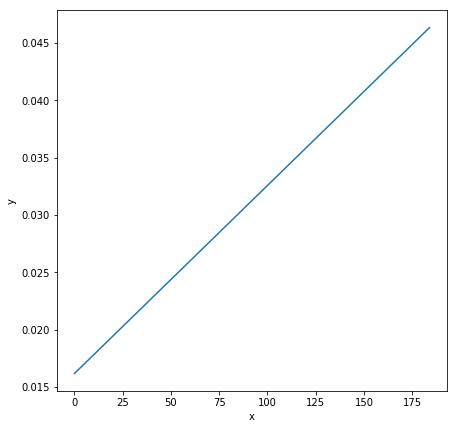

In [18]:
x = range(len(lr_find_lr))
data = pd.DataFrame(data={'y': lr_find_lr, 'x': x})
f, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=data.x, y=data.y, ax=ax)
plt.show()